# Convolution Neural Network (CNN) 
# Implemented using PyTorch, Tensorboard 
A [CNN is distiguisable from an MLP](https://youtu.be/YRhxdVk_sIs?t=49) (general multilayer paerceptron) - convolutional layers. [Two of the popular ways a CNN can be trained](https://youtu.be/K_BHmztRTpA?t=247) - autoencoder (for unlabeled data) & GAN ().
- **Convolution layer** A [convolution filter](https://youtu.be/YRhxdVk_sIs?t=392) is convolved on the whole image. Conv layers at the starting of the network are more basic (maybe detects edges etc.), but the deeper we go into the network, [the conv filters are generally more complex](https://youtu.be/cNBBNAxC8l4?list=PLZbbT5o_s2xq7LwI2y8_QtvuXZedL6tQU&t=295) and capable of detecting advanced features (like whole bird, dog face etc.). [Convolutional layers are typically followed by ReLu, which will discard all the negative values](https://youtu.be/vJiZqZRkIg8?list=PLZbbT5o_s2xq7LwI2y8_QtvuXZedL6tQU&t=493). The reduction of image size ([n-f+1](https://youtu.be/qSTv_m-KFk0?list=PLZbbT5o_s2xq7LwI2y8_QtvuXZedL6tQU&t=312), where n=input & f=filter size in one axis) due to convolution can be using [zero padding](https://youtu.be/qSTv_m-KFk0?list=PLZbbT5o_s2xq7LwI2y8_QtvuXZedL6tQU&t=624).
- **Pooling Layer** [Pooling can be of two types](https://youtu.be/K_BHmztRTpA?t=210) - **Maxpooling** (takes maximum of a particular convolved feature) & **Average Pooling**. Maxpooling is useful because it can - 1. reduce image size ([downsampling](https://youtu.be/pDdP0TFzsoQ?t=212)), 2.reduce overfitting (by provding a more abstract form of the input). If stride (move) of 2 & filter (or kernel) size of 2x2 is used, then the [resulting image size would be half on each axis](https://youtu.be/kt6iUG0Gfm0?list=PLZbbT5o_s2xq7LwI2y8_QtvuXZedL6tQU&t=288).

![](basicCNN.pdf)

# Imports

In [6]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torch.nn.functional as F

# import tensorflow as tf
import tensorboard as tb
from torch.utils.tensorboard import SummaryWriter

## Tensorboard

In [7]:
# tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
import sys
writer = SummaryWriter('runs/mnist1')

## Set device
- [gpu-acceleration-comes-to-pytorch-on-m1-macs-195c399efcc1](https://towardsdatascience.com/gpu-acceleration-comes-to-pytorch-on-m1-macs-195c399efcc1)

In [8]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import platform
print(platform.platform())
print(torch.has_mps) #torch.backends.mps.is_available()
device = torch.device("mps" if torch.has_mps else "cpu") #M1 Mac
# device = torch.device("cpu")
# register_buffer(attr = attr.to(torch.device("mps"), torch.float32))

macOS-13.3.1-arm64-arm-64bit
True


## Hyperparameters

In [9]:
input_size = 784 # 28x28
hidden_size = 500
num_classes = 10
num_epochs = 1
batch_size = 64
learning_rate = 0.001

## (Down)Load Data

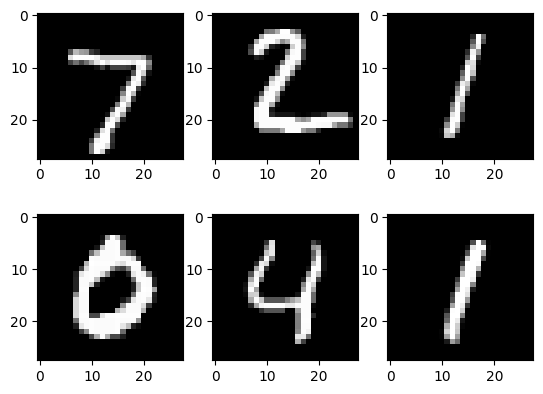

In [10]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='../../data/', 
                                           train=True, 
                                           transform=T.ToTensor(),  
                                           download=True)

val_dataset = torchvision.datasets.MNIST(root='../../data', 
                                          train=False, 
                                          transform=T.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

example_data, example_targets = next(iter(val_loader)) # previously `examples.next()`

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
#plt.show()

In [11]:
example_data.reshape(-1, 28*28)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

## Simple CNN

In [12]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        # no activation and no softmax at the end
        return out

model = NeuralNet(input_size, hidden_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

# TENSORBOARD

## Model training

In [13]:
running_loss = 0.0
running_correct = 0
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # origin shape: [100, 1, 28, 28]
        # resized: [100, 784]
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images).to(device)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        running_correct += (predicted == labels).sum().item()
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            ############## TENSORBOARD ########################
            writer.add_scalar('training loss', running_loss / 100, epoch * n_total_steps + i)
            running_accuracy = running_correct / 100 / predicted.size(0)
            writer.add_scalar('accuracy', running_accuracy, epoch * n_total_steps + i)
            running_correct = 0
            running_loss = 0.0
            ###################################################

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
class_labels = []
class_preds = []
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in val_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images).to(device)
        # max returns (value ,index)
        values, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        class_probs_batch = [F.softmax(output, dim=0) for output in outputs]

        class_preds.append(class_probs_batch)
        class_labels.append(predicted)

    # 10000, 10, and 10000, 1
    # stack concatenates tensors along a new dimension
    # cat concatenates tensors in the given dimension
    class_preds = torch.cat([torch.stack(batch) for batch in class_preds]).to(device)
    class_labels = torch.cat(class_labels).to(device)

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

    ############## TENSORBOARD ########################
    classes = range(10)
    for i in classes:
        labels_i = class_labels == i
        preds_i = class_preds[:, i]
        writer.add_pr_curve(str(i), labels_i, preds_i, global_step=0)
        writer.close()
    ###################################################
    
    ############## TENSORBOARD ########################
    img_grid = torchvision.utils.make_grid(example_data.to("cpu"))
    writer.add_image('mnist_images', img_grid)
    writer.close()
    #sys.exit()
    ###################################################

    ############## TENSORBOARD ########################
    writer.add_graph(model.to("cpu"), example_data.reshape(-1, 28*28))#.to(device)
    writer.close()
    # sys.exit()
    ###################################################

Epoch [1/1], Step [100/938], Loss: 0.4700
Epoch [1/1], Step [200/938], Loss: 0.1139
Epoch [1/1], Step [300/938], Loss: 0.2724
Epoch [1/1], Step [400/938], Loss: 0.1538
Epoch [1/1], Step [500/938], Loss: 0.1848
Epoch [1/1], Step [600/938], Loss: 0.1182
Epoch [1/1], Step [700/938], Loss: 0.0592
Epoch [1/1], Step [800/938], Loss: 0.0835
Epoch [1/1], Step [900/938], Loss: 0.0455
Accuracy of the network on the 10000 test images: 96.2 %


In [16]:
%load_ext tensorboard
#%tensorboard --logdir ("runs")#/MNIST/MiniBatchSize {batch_size} LR {learning_rate}")
%tensorboard --logdir runs/mnist1 #logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Launching TensorBoard...

# <a name="references"></a> References
- **Backpropagation** ([intuitive understanding](https://www.youtube.com/watch?v=XE3krf3CQls&list=PLZbbT5o_s2xq7LwI2y8_QtvuXZedL6tQU&index=25&t=280s)). 
- **Gradient Descent** Gradient means the gradient of loss with respect to the weights.
- **Weight Initialization** [intuitive understanding](https://youtu.be/8krd5qKVw-Q?list=PLZbbT5o_s2xq7LwI2y8_QtvuXZedL6tQU&t=43)
- **Bias** [Intuitive understanding](https://www.youtube.com/watch?v=HetFihsXSys&list=PLZbbT5o_s2xq7LwI2y8_QtvuXZedL6tQU&index=32)
- **Batch Size** [batch size](https://youtu.be/U4WB9p6ODjM?list=PLZbbT5o_s2xq7LwI2y8_QtvuXZedL6tQU&t=83)

- [What is a convolutional neural network (CNN)?](https://youtu.be/K_BHmztRTpA?t=148)
- [Convolutional Neural Network (CNN)](https://youtu.be/pDdP0TFzsoQ)
- [CNN architecture](https://youtu.be/c36lUUr864M?t=12104)
- [GitHub patrickloeber 16_tensorboard.py](https://github.com/patrickloeber/pytorchTutorial/blob/e6dd99c0ffed3492bf35dcb790ae10a8170e93e8/16_tensorboard.py)
- [What is the ideal value of num_workers?](# http://www.feeny.org/finding-the-ideal-num_workers-for-pytorch-dataloaders/)

"""
This is a simpler version intended for checking if `mps` can be used. Currently getting 
error in the original notebook: 
`Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support 
float64. Please use float32 instead.`
"""